# YOLO Gesture Detection

This small project features the detection of several hand gestures with a YOLOv5 model by Ultralytics, which is built on PyTorch. A custom YOLOv5 model is loaded, trained, and utilized. In addition, opencv is used in combination with said model to perform live detection.

## Table of Contents

- [All Links in Document](#links)
- [Imports](#imports)
- [Create Model](#create)
- [Train Model](#train)
- [Evaluate Model](#evaluate)

## All Links in Document <a name="links" />

- https://github.com/ultralytics/yolov5
- https://pytorch.org/hub/ultralytics_yolov5/
- https://universe.roboflow.com/yolo-zxvpk/hand-gesture-r7qgb/dataset/6
- https://opencv.org/

## Imports <a name="imports" />

In [3]:
# Imports
import torch
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import cv2
from PIL import Image
import random

In [4]:
# Torch version
torch.__version__

'1.12.1+cu113'

In [5]:
# Matplotlib default backend
matplotlib.get_backend()

'module://matplotlib_inline.backend_inline'

## Create Model <a name="create" />

This project utilizes the YOLOv5 model by Ultralytics for object detection. There are many ways to make use of it, with all information available in its respective GitHub repository: https://github.com/ultralytics/yolov5

The YOLOv5 model is built on the PyTorch framework, and it is available in the PyTorch hub as well: https://pytorch.org/hub/ultralytics_yolov5/. This makes it very convenient to import by making use of `torch.hub.load`.

In [5]:
# Loading a YOLOv5 model from the PyTorch hub
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

C:\Users\29775\anaconda3\envs\HandGesture\Lib\site-packages\torch\hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\29775/.cache\torch\hub\master.zip


requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
   ---------------------------------------- 195.4/195.4 kB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 62.7/62.7 kB ? eta 0:00:00

requirements: AutoUpdate success ✅ 5.3s, installed 1 package: ['gitpython>=3.1.30']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


YOLOv5  2024-3-6 Python-3.11.8 torch-2.2.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


There are multiple architectural versions of the YOLOv5 model available:

- YOLOv5n (Nano)
- YOLOv5s (Small)
- YOLOv5m (Medium)
- YOLOv5l (Large)
- YOLOv5x (Extra large)

The main difference between these model architectures, as their names imply, is their size. Each following model is larger in size, trained on more data, and takes longer to compute. This means that smaller models will be more compact and faster to use, but accuracy may suffer. For this project's use case, a small YOLOv5 model will be utilized.

Some information is given once the YOLOv5s model is loaded, showing that even a small version of the model boasts a large quantity of layers and parameters.

<img src="images/yolov5load.png" align="left" />

This model can be used right away as it's pretrained on several random classes such as people, ties, cats, etc. One example, taken directly from the PyTorch hub page for YOLOv5, can be used to show how the model functions. This example image features Zinedine Zidane, a French association football manager.

In [6]:
# Using the model on an example image
example = 'data/custom/zidane.jpg'
results = model(example)

It's possible to inspect the model's results by converting the `results` variable to a Pandas DataFrame with `.pandas()` and calling `.xyxy[0]`. The resulting DataFrame will show coordinates for where bounding boxes start and end for detected classes, which classes were detected, the class names, and how confident the model is in its discoveries.

In [7]:
results.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,743.290527,48.343597,1141.756470,720.000000,0.879861,0,person
1,441.989624,437.336670,496.585083,710.036255,0.675119,27,tie
2,123.051117,193.237976,714.690552,719.771362,0.666693,0,person
3,978.989807,313.579468,1025.302734,415.526184,0.261516,27,tie


It's also possible to observe the image with bounding boxes drawn using `results.show()`. Another method is shown below, using Matplotlib, as this method takes up less space and is more customizable. 

It's also important to note that importing the YOLOv5 model messes with Matplotlib's backend. Matplotlib can use several backends, changing the behaviour for showing images and several other matters. By default, Matplotlib's backend is `module://matplotlib_inline.backend_inline`. However, after importing a YOLOv5 model, it's changed to `agg`. Using `%matplotlib inline` at the start of a code cell is necessary to ensure that images are shown inline.

In [8]:
# Matplotlib altered backend
matplotlib.get_backend()

'agg'

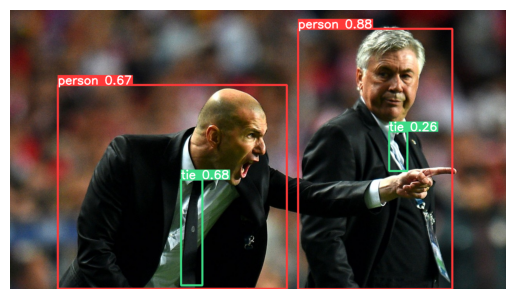

In [9]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()

In [10]:
# Matplotlib backend after using %matplotlib inline
matplotlib.get_backend()

'module://matplotlib_inline.backend_inline'

## Train Model <a name="train" />

While the pretrained YOLOv5 model is functional, it only works on a bunch of random classes unrelated to the goal of this project. For this reason, it's necessary to train a custom model from scratch, using custom data. The Hand Gesture Image Dataset (latest version) from Roboflow was utilized for this project: https://universe.roboflow.com/yolo-zxvpk/hand-gesture-r7qgb/dataset/6

By default, this dataset features over 1900 training images, 72 validation images, and 69 testing images. In addition, it's possible to download it in the correct YOLOv5 format. It's very important that the directories are arranged as follows:

- dataset/
    - test/
        - images/
        - labels/
    - train/
        - images/
        - labels/
    - valid/
        - images/
        - labels/

Each of the testing, training, and validation folders contain two additional folders. The images folder will naturally contains the images for that dataset, and the labels folder contain text files for each corresponding image. Each text file contains the numerical classes and coordinates for the bounding boxes of where said classes are found in the image.

Label text file example:

<img src="images/labelexample.png" align="left" />

The training of a custom model is not actually done with PyTorch, even though YOLOv5 is built on PyTorch and it's downloaded from the PyTorch hub. It's first necessary to download the entire YOLOv5 GitHub repository into the project (https://github.com/ultralytics/yolov5). Afterwards, it's necessary to alter the `dataset.yaml` file found in the YOLOv5 repository folder. The `dataset.yaml` file contains the paths of the differen datasets. In addition, the classes and number of classes are shown here as well.

<img src="images/datasetyaml.png" align="left" />

The above image shows that there are 7 total classes for various hand gestures. It's critical for everything to be set up in this manner or else the model training will cause errors. when everything is set up correctly, the training of a custom model is performed by calling `train.py` in a terminal. Training was performed with the following Python command:

In [12]:
!cd yolov5 && python train.py --img 640 --batch 32 --epoch 10 --data dataset.yaml --weights yolov5s.pt --workers 2

^C


Several hyperparameters are set to ensure that everything runs smoothly:

- --img: The image size is set to 640, which is the default value
- --batch: The batch size of images to use at once per training step
- --epoch: The number of epochs to train for
- --data: The dataset.yaml file that shows the model where all data and labels are located
- --weights: The type of weights the model will output
- --workers: The number of CPU cores to utilize

As training completes, results are saved in the `YOLOv5/runs/train` directory.

## Evaluate Model <a name="evaluate" />

After a training run, a lot of information is saved in various formats.

In [1]:
# Loading the training results CSV
custom_df = pd.read_csv("yolov5/runs/train/exp/results.csv")
custom_df.head()

NameError: name 'pd' is not defined

The results CSV shows the progression of all kinds of losses and metrics. It's important to note that as the training progresses through the epochs, the loss values decrease and metric values increase.

In [11]:
# Progressive increase in metric scores
custom_df[["   metrics/precision", "      metrics/recall", "     metrics/mAP_0.5"]]

,metrics/precision,metrics/recall,metrics/mAP_0.5
0,0.064797,0.24546,0.067635
1,0.254240,0.49574,0.334470
2,0.294310,0.51095,0.368290
3,0.510550,0.67119,0.683580
4,0.535730,0.75824,0.630030
5,0.579900,0.73657,0.680890
6,0.807010,0.80203,0.847550
7,0.816540,0.81450,0.869730
8,0.767730,0.84009,0.851180
9,0.802410,0.79547,0.869390


Several plots containing these values are combined into a single image, whose results can be observed as well:

<img src="images/results.png" />

The overall loss of the YOLOv5 is comprised of `val/box_loss`, `val/obj_loss`, and `val/cls_loss`. These losses are calculated for both the training dataset and the validation dataset. These losses have the following meaning:

- box_loss: Bounding box regression loss (Mean Squared Error).
- obj_loss: The confidence of object presence is the objectness loss.
- cls_loss: The classification loss (Cross Entropy).

In addition the metrics have the following meaning:
- precision: Measures how many of the bbox predictions are correct (True positives / (True positives + False positives))
- recall: Measures how many of the true bbox were correctly predicted (True positives / (True positives + False negatives))
- mAP_0.5: The mean Average Precision (mAP) at IoU (Intersection over Union) threshold of 0.5.
- mAP_0.5:0.95: The average mAP over different IoU thresholds, ranging from 0.5 to 0.95.

A confusion matrix can also be observed to see how well the model fares for the various classes.

<img src="images/confusion_matrix.png" />

It's visible that the model performs well for most of the classes. It does seem to have some difficulty with differentiating pointing towards the right with pointing towards different directions. This seems like an expected issue as pointing is not very visually distinct. The thumbs down and thumbs up classes, while potentially confusing as well, do seem to perform much better.It's important to note that training was performed for only 10 epochs. Training on additional epochs may improve the results even more.

A custom model is loaded in a similar way as before, using `torch.hub.load` once again. This time, it's important to specify "custom" instead of the specific architecture, and by supplying a path, the weights of a specific training run can be loaded.

In [25]:
model_custom = torch.hub.load("ultralytics/yolov5", "custom", path="yolov5/runs/train/exp/weights/best.pt")

Using cache found in C:\Users\Linun/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-3-7 Python-3.9.16 torch-1.12.1+cu113 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7029004 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


As the testing dataset remained untouched during the training process, it contains only fresh data that the model has not seen before. Random batches of data can be taken and observed to get an idea of how well the model performs.

In [26]:
# Getting all test images using .glob() based on Windows paths
TEST_DIR = Path(f"data/Hand Gesture.v6i.yolov5pytorch/test/images")
test_samples = list(TEST_DIR.glob("*.jpg"))

In [27]:
# Number of available test samples
len(test_samples)

69

In [28]:
# Grabbing 9 random samples
random.seed(40)
random_samples = random.sample(test_samples, 9)

In [29]:
# Sample URLs
random_samples

[WindowsPath('data/Hand Gesture.v6i.yolov5pytorch/test/images/images87-2-_jpg.rf.2df1b59563d9781f964d09c9e68ed0a5.jpg'),
 WindowsPath('data/Hand Gesture.v6i.yolov5pytorch/test/images/WIN_20220411_15_53_55_Pro_jpg.rf.f49b260874b49ac700ff65a279dd6179.jpg'),
 WindowsPath('data/Hand Gesture.v6i.yolov5pytorch/test/images/images43_jpg.rf.7af474d9653fb122a5acfa33f4df6dc2.jpg'),
 WindowsPath('data/Hand Gesture.v6i.yolov5pytorch/test/images/images64-1-_jpg.rf.ad42fb5a13656dd04a553149b3a83805.jpg'),
 WindowsPath('data/Hand Gesture.v6i.yolov5pytorch/test/images/images68_jpg.rf.f78e6dc2596bf3763b37e7bed355c2c7.jpg'),
 WindowsPath('data/Hand Gesture.v6i.yolov5pytorch/test/images/images60-2-_jpg.rf.696299a46ad017766e1929f9f598b566.jpg'),
 WindowsPath('data/Hand Gesture.v6i.yolov5pytorch/test/images/images45-2-_jpg.rf.24730d4459c2f73c461b64b485649c89.jpg'),
 WindowsPath('data/Hand Gesture.v6i.yolov5pytorch/test/images/images76_jpg.rf.958bea2e8a88e1aad26858abbb454908.jpg'),
 WindowsPath('data/Hand Ges

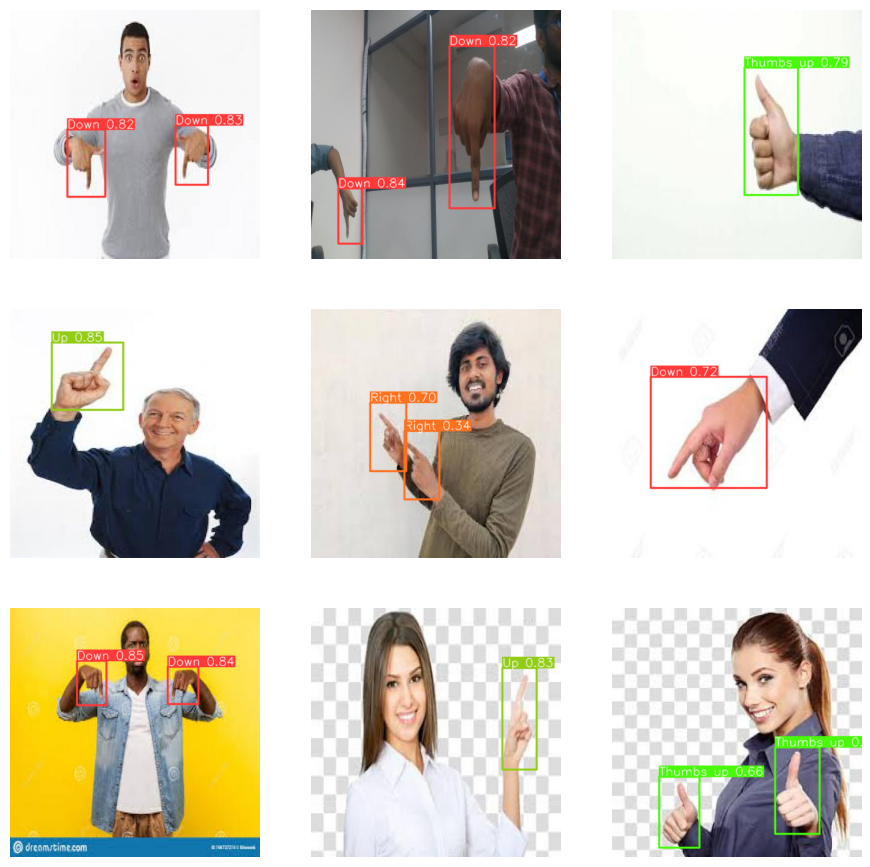

In [30]:
# Predicting the random samples
%matplotlib inline
fig = plt.figure(figsize=(11, 11))
rows, cols = 3, 3
for i, sample in enumerate(random_samples):
    plt.subplot(rows, cols, i+1)
    result = model_custom(sample)
    plt.imshow(np.squeeze(result.render()))
    plt.axis(False)

The randomized sample gives an idea of the results when the model is used on actual images. The model is capable of correctly differentiating the various directions that people can point in. Naturally, some images are more obscure as people pointing in certain directions don't perfectly follow cardinal directions. It's to be expected that some hand gestures are angled diagionally and that some predictions will not be perfect.

The model can also be tested on custom images of yourself! An example is shown below:

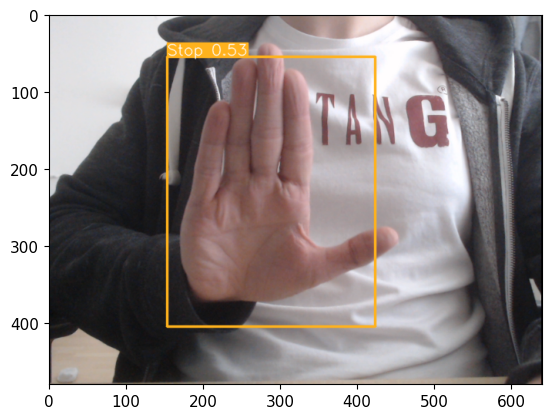

In [7]:
%matplotlib inline
img = f"data/custom/Screenshot 2023-04-29 17-55-29.png"
results = model_custom(img)
plt.imshow(np.squeeze(results.render()))
plt.show()

It's also possible to utilize the model on videos or during live capture with a webcam. Using opencv (https://opencv.org/) will allow for videos and webcams to be easily utilized in a Jupyter Notebook environment. However, depending on CPU/GPU processing power, it may be rather slow.

In [11]:
cap = cv2.VideoCapture("images/2023-05-09 11-26-38.mp4")

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break

    pred = model_custom(frame)
    cv2.imshow("Output", np.squeeze(pred.render()))
    
    if cv2.waitKey(10) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

The above code cell contains an opencv solution that reads a prerecorded video in mp4 format and plays it, calling the custom model on every frame, and showing the results. After execution, recording, and some video editing magic, the following gif shows how the model performs during live detection:

<img src="images/livedetection.gif" />